In [64]:
import numpy as np
import scipy as sp
from numba import njit
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def plot_loss(x, y_pred):
    sampled_index = np.sort(np.random.choice(len(x), min(1000, len(x)), replace=False))
    
    x = x[sampled_index]
    y_pred = y_pred[sampled_index]
    y_truth = np.array([solution(x) for x in x])

    diff = abs(y_truth - y_pred)
    losses = - np.log10(np.clip(diff, 1e-17, np.inf))

    plt.figure(figsize=(16, 8))
    plt.title('Абсолютная погрешность', fontsize=16)
    
    for i in range(4):
        plt.plot(x, losses[:, i], label=f'y{i}')

    plt.legend(loc='best')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('- log10(|y_pred - y_true|)', fontsize=12)
    
    
def plot_h(pos, hs):
    plt.figure(figsize=(16, 8))
    plt.plot(pos, hs, label='h')
    plt.legend(loc='best')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('hs', fontsize=12)
    
def plot(title, y, x=None):
    x = np.arange(len(y)) if x is None else x
    
    fig = plt.figure()
    plt.figure(figsize=(16,6), dpi= 80)
    plt.title(title, fontsize=17)

    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    plt.grid(axis='both', alpha=.3)

    plt.plot(x, y, color='tab:red');
    plt.show();

# Постановка задачи

Необходимо решить систему дифференциальных уравнений в области определения функции f.

$$ \frac{dy}{dx} = f(x, y) $$

При наличии начальных условий

$$y\left(x_{0}\right)=y_{0}$$

где в общем случае $y$ вектор функция $ y = (y^1, y^2, ..., y^n)$



# Явный метод Рунге
Воспользуемся разложением Тейлора в точке $x_i$ для вычисления значения функции в точке $x_{i+1}$

$$
y\left(x_{i+1}\right)=y\left(x_{i}\right)+h y^{\prime}\left(x_{i}\right)+\frac{h^{2}}{2} y^{\prime \prime}\left(x_{i}\right)+\ldots+\frac{h^{s}}{s !} y^{(s)}\left(x_{i}\right)
+\frac{h^{s+1}}{(s+1) !} y^{(s+1)}(\xi)\\ y\left(x_{i+1}\right) = 
y\left(x_{i}\right)+\triangle\left(x_{i}, y\left(x_{i}\right), h\right)
$$

Но так как вычисление $\triangle\left(x_{i}, y\left(x_{i}\right), h\right)$ проблематично в общем случае (нужно брать частные производные). Воспользуемся приближением, предложенным Рунге, Хойном и Куттом.

$$
\varphi(x, y(x), h)=\sum_{i=1}^{m} b_{i} k_{i}(h) \\
\text { где } \quad k_{i}(h)=h f\left(x+h c_{i}, y(x)+\sum_{j=1}^{i-1} a_{i j} k_{j}\right) \quad i=1,2, \ldots, m
$$

И будем искать решение в виде 
$$
y(x+h) \approx y(x)+\sum_{i=1}^{m} b_{i} k_{i}(h)
$$

Коэффициенты метода будем находить из условия равенства порядка метода числу s. Для этого возьмем методическую погрешность метода $\Psi(h)$.

$$
\Psi(h)=y(x+h)-y(x)-\sum_{i=1}^{m} b_{i} k_{i}(h)
$$

Раскладываем в ряд $\Psi(h)$ в точке 0

$$
\Psi(h)=\sum_{i=0}^{s} \frac{\Psi^{(i)}(0)}{i !} h^{i}+\frac{\Psi^{(s+1)}(\theta h)}{(s+1) !} h^{s+1}
$$

И находим коэффициенты из равенств 0 производных $\Psi(h)$ в точке 0 (Если это можно сделать). При m = 2 мы имеем двух этапный метод Рунге

Для практической реализации определим f(x, y) - как систему дифференциальных уравнений:

$$
\left\{\begin{array}{l}
y_{1}^{\prime}(x)=2 x\left(y_{2}(x)\right)^{\frac{1}{B}} y_{4}(x), \\
y_{2}^{\prime}(x)=2 B x \exp \left(\frac{B}{C}\left(y_{3}(x)-A\right)\right) y_{4}(x), \\
y_{3}^{\prime}(x)=2 C x y_{4}(x) \\
y_{4}^{\prime}(x)=-2 x \ln y_{1}(x),
\end{array}\right.
$$

С начальными условиями $y_{1}(0)=y_{2}(0)=y_{4}(0)=1, y_{3}(0)=A$ при $x \in [0, 4]$

Причем нам известно решение этой системы:

$$
\begin{array}{ll}
y_{1}(x)=\mathrm{e}^{\sin x^{2}}, & y_{3}(x)=C \sin x^{2}+A, \\
y_{2}(x)=\mathrm{e}^{B \sin x^{2}}, & y_{4}(x)=\cos x^{2}
\end{array}
$$
Ниже я определяю эти функции

In [2]:
@njit
def f(x, y, A=1, B=1, C=1, count=False):
    values_f = np.array([2 * x * y[1] ** (1/B) * y[3],
                         2 * B * x * np.exp(B / C * (y[2] - A)) * y[3],
                         2 * C * x * y[3],
                         - 2 * x * np.log(y[0])], dtype=np.float64)
    
    return values_f

In [3]:
def solution(x, A=1, B=1, C=1):
    values_sol = np.array([np.exp(np.sin(x ** 2)),
                         np.exp(B * np.sin(x ** 2)),
                         np.sin(x ** 2) * C + A,
                         np.cos(x ** 2)])
    return values_sol

Так же добавим в наш метод Рунге алгоритм выбора начального шага для уменьшение вычислительных затрат

1. Вычислить $f\left(x_{0}, y_{0}\right) ;$
2. Найти
$$
\Delta=\left(\frac{1}{\max \left(\left|x_{0}\right|,\left|x_{k}\right|\right)}\right)^{p+1}+\left|f\left(x_{0}, y_{0}\right)\right|^{p+1} ;
$$
3. Выбрать начальный шаг
$$
h_{1}=\left(\frac{t o l}{\Delta}\right)^{\frac{1}{p+1}}
$$
4. Если в правой части много нулей, нужно сделать шаг Эейлера и посчить h1.

Как описано ниже в функции choice_first_partition

In [4]:
from numpy.linalg import norm


@njit(fastmath=True)
def choice_first_partition(f, x0, y0, tolerance, x_end, p=2):
    """ Function for estimation first value of h """
    denominator = (1 / max(np.abs(x_end), np.abs(x0))) ** (p + 1) + np.sum(np.abs(f(x0, y0)))      
    h = (tolerance / denominator) ** (1 / (p + 1))

    x1 = x0 + h
    y1 = y0 + h * f(x0, y0)
    
    denominator = (1 / max(np.abs(x_end), np.abs(x1))) ** (p + 1) + np.sum(np.abs(f(x1, y1)))
    h1 = (tolerance / denominator) ** (1 / (p + 1))
    
    return min(h, h1)


In [5]:
@njit
def _runge_method(f, x0, y0, h, params):
    """ 2ух этапный метод Рунге-Кутты  """
    a21, c2, b2, b1 = params
    
    k1 = h * f(x0, y0)
    k2 = h * f(x0 + c2 * h, y0 + a21 * k1 * h)
    
    y = y0 + b1 * k1 + b2 * k2
    
    return y

Помимо начального выбора h, будем оценивать погрешность и брать такое h, которое нам дает требуемую точность. Это похоже на то, как мы делали при подсчете интеграла. Берем 2 сетки, и оцениваем погрешность, предполагая, что мы в асимптотической области

$$
\begin{array}{c}
y\left(x_{n}\right)-\bar{y}_{n}=\zeta\left(x_{n}\right) h^{p}+O\left(h^{p+1}\right) \\
y\left(x_{n}\right)-\tilde{y}_{2 n}=\zeta\left(x_{n}\right)\left(\frac{h}{2}\right)^{p}+O\left(h^{p+1}\right)
\end{array}
$$

Выражая $\zeta\left(x_{n}\right)$ и приравнивая правые части, получим

$$
\begin{array}{l}
\bar{R}_{n}=y\left(x_{n}\right)-\bar{y}_{n}=\frac{\tilde{y}_{2 n}-\bar{y}_{n}}{1-2^{-p}}+O\left(h^{p+1}\right) \\
\tilde{R}_{2 n}=y\left(x_{n}\right)-\tilde{y}_{2 n}=\frac{\tilde{y}_{2 n}-\bar{y}_{n}}{2^{p}-1}+O\left(h^{p+1}\right)
\end{array}
$$

Отсюда находим оптимальный шаг

$$
h_{t o l} \approx h\left(\frac{t o l}{\left|\bar{R}_{n}\right|}\right)^{\frac{1}{p}}=\frac{h}{2}\left(\frac{t o l}{\left|\tilde{R}_{2 n}\right|}\right)^{\frac{1}{p}}
$$



In [6]:
@njit(fastmath=True)
def runge_method_global(f, x0, y0, x_end, params, h):
    """ Two-stage runge method for solving differential equations """
    calculating_f_count = 0
    # создаем сетки
    n_polints = int((x_end - x0) // h)
    
    y = np.zeros(len(y0), dtype=np.float64) + y0
    y_on_each_step = np.zeros((n_polints, len(y)))
    
    for i, x in enumerate(np.linspace(x0, x_end, n_polints)):
        # делаем один шаг
        y = _runge_method(f, x, y, h, params)
        
        # сохраняем информацию
        y_on_each_step[i] = y
        calculating_f_count += 2
    
    return np.linspace(x0, x_end, n_polints), y_on_each_step, calculating_f_count


@njit(fastmath=True)
def _solver_diff_equations_global(f, x0, y0, params, h, tolerance=0.1, p=2):
    inaccuracy_on_second_grid = np.inf
    calculating_f_count = 0
    
    while inaccuracy_on_second_grid > tolerance:
        # Берем 2 сетки
        grid, answ_first_grid, count_f_1 = runge_method_global(f, x0, y0, x_end, params, h)        
        grid, answ_second_grid, count_f_2 = runge_method_global(f, x0, y0, x_end, params, h / 2)
        
        # Запоминаем количество операций
        calculating_f_count += count_f_1 + count_f_2
        
        # Считаем погрешность и новый шаг
        inaccuracy_on_second_grid = norm(answ_second_grid[-1] - answ_first_grid[-1]) / (2 ** p - 1)         
        h *= (tolerance / inaccuracy_on_second_grid) ** (1 / p) / 2
        
    return grid, answ_second_grid, calculating_f_count

In [7]:
@njit(fastmath=True)
def solver_diff_equations(f, x0, y0, x_end, params, tolerance=0.1, rtol=0.1, 
                          atol=0.1, aplha=1, p=2, return_count=False, use_local=False):
    
    """ The main function for users contains an automatic choice of steps and error estimation """
    calculating_f_count = 0
    h = min(1e-3, choice_first_partition(f, x0, y0, tolerance, x_end))
    
    if use_local:
        raise NotImplementedError #пока не реализовали локалькую погрешность, будет дальше
    else:
        x, y, info = _solver_diff_equations_global(f, x0, y0, params, h, tolerance)
    return x, y, info


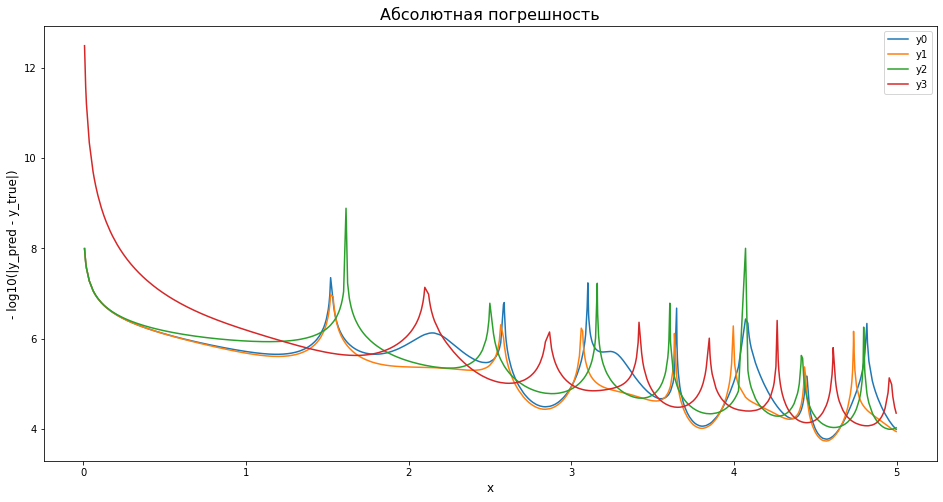

In [8]:
# Задаем начальные условия и параметры
A, c2 = 1, 1/3
params = [c2, c2, 1/2/c2, 1-1/2/c2]
x0, y0 = 0, np.array([1, 1, A, 1], dtype=float)
x_end = 5

x, y_pred, f_count = solver_diff_equations(f, x0, y0, params=params, 
                                           x_end=x_end, tolerance=1e-4)

plot_loss(x, y_pred)

Видно, что метод работает корректно. При заданной точности мы почти всегда находимся выше 1e-4

In [9]:
for tol in [1e-1, 1e-2, 1e-3, 1e-4]:
    x, y_pred, f_count = solver_diff_equations(f, x0, y0, params=params, 
                                               x_end=x_end, tolerance=tol)
    
    print(f"При {tol = }, h = {x[1]-x[0]}, количество обрщаений к f = {f_count}")

При tol = 0.1, h = 0.0005001000200040008, количество обрщаений к f = 29996
При tol = 0.01, h = 0.00010755695140576936, количество обрщаений к f = 169460
При tol = 0.001, h = 1.001255574490411e-05, количество обрщаений к f = 1969148
При tol = 0.0001, h = 7.32335267772532e-07, количество обрщаений к f = 30283426


Видим очень бурный рост h, f при разных tol, что может привести к огромной методической погрешности. Поэтому встает вопрос о новом подходе, который будет вычислительно проще. Одно из возможных решений - оценивать h с помощью локальной погрешности

Будем оценивать локальную погрешность и брать соответствующее h на каждом шаге по следующему правилу

1) Берем 2 "сетки". 1 шаг размера h и 2 шага h/2

2) Вычисляем локальную погрешность $R_{1}=\frac{y_{2 n}-y_{n}}{1-2^{-p}}$, и $R_{2}=\frac{y_{2 n}-y_{n}}{2^{p}-1}$

3) Сравниваем с порогом и $R_{2}<$ rtol $\cdot|y|+$ atol (или max(rtol $\cdot|y|,$ atol))

4) Если погрешность не подходит, выбираем $h_{t o l} \approx 0.9 \cdot \frac{h}{2}\left(\frac{t o l}{\left|\tilde{R}_{2 n}\right|}\right)^{\frac{1}{p}}$

In [85]:
@njit(fastmath=True)
def local_R2_R1_y2(f, x, y, params, h, p=2):
    """ Делаем шаг h и 2 шага h/2, считаем погрешность"""
    y1 = _runge_method(f, x, y, h, params) 
    
    y2 = _runge_method(f, x, y, h/2, params)
    y2 = _runge_method(f, x + h/2, y2, h/2, params) 
    
    R2 = norm(y2 - y1) / (2 ** p - 1) # чтобы не было 0
    R1 = norm(y2 - y1) / (1 - 2 ** (-p))
    
    R2 = 1e-20 if R2 == 0 else R2
    R1 = 1e-20 if R1 == 0 else R1

    return R2, R1, y2, y1


@njit(fastmath=True)
def runge_method_local(f, x0, y0, params, h, rtol, atol, p=2):
    """ Пока погрешность не будет меньше заданной, уменьшаем h """
    calculating_f_count = float(6)
    R2, R1, y2, y1 = local_R2_R1_y2(f, x0, y0, params, h)

    while R2 > (tol:=min(norm(y2) * rtol, atol)):
        h *= 0.9 * (tol / R2) ** (1 / (p + 1)) / 2
        R2, R1, y2, y1 = local_R2_R1_y2(f, x0, y0, params, h)
        
        calculating_f_count += 6
    
    h *= (tol / R2) ** (1 / (p + 1)) / 2
    
    return y2, h, calculating_f_count, R2

In [86]:
# @njit(fastmath=True)
def _solver_diff_equations_local(f, x0, y0, x_end, params, h, rtol=1e-6, atol=1e-10, p=2):
    calculating_f_count = float(0)
    xs, ys, hs, rs = [], [], [], []
    x, y = x0, y0
    
    # Будем шагать, пока не выйдем за границы
    while x < x_end:
        # Шагаем локальным методом Рунге
        y, h, calc_f, r = runge_method_local(f, x, y, params, h, rtol, atol, p)
        
        # Заполняем информацию
        for el, array in zip([x, y, h, r], [xs, ys, hs, rs]):
            array.append(el)
        
        calculating_f_count += calc_f
        x += h
        
    return np.array(xs, dtype=float), np.array(ys, dtype=float), (hs, rs, calculating_f_count)

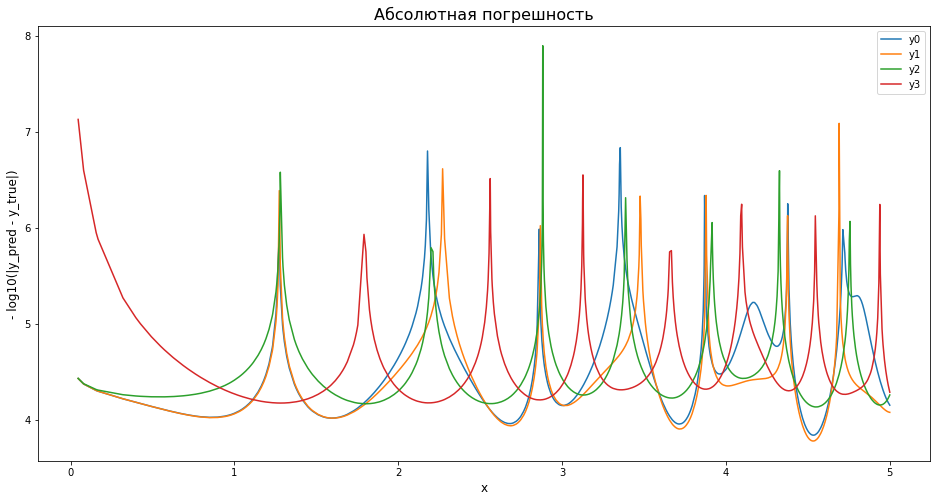

In [32]:
A, c2 = 1, 1/3
params = [c2, c2, 1/2/c2, 1-1/2/c2]

x0, y0 = 0, np.array([1, 1, A, 1])
x_end = 5

x, y_pred, info = _solver_diff_equations_local(f, x0, y0, params=params, x_end=x_end, 
                                           h=1e-6, rtol=1e-4, atol=1e-10)
h, r, num_calc = info
plot_loss(x, y_pred)

<Figure size 432x288 with 0 Axes>

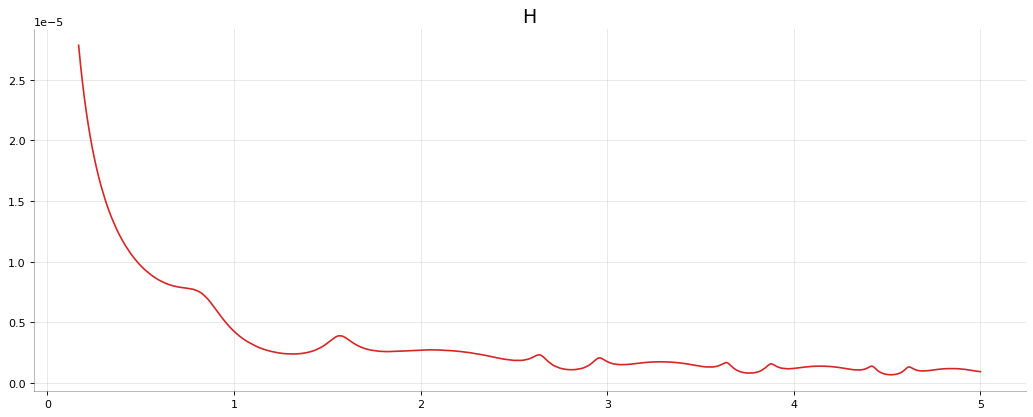

In [67]:
plot('H', h[3000:], x[3000:])
# Видно, что алгоритм циклически изменяет h

А теперь оценим наш алгоритм по надежности и объему вычислений 

Метод считается надежным, если он способен регулировать величину локальной погрешности, с помощью изменения длины шага. Воспользуемся алгоритмом Рунге-Кутты 4ого порядка в качестве истинной локальной погрешности 

$$
\eta_{n}=\left|\frac{\varrho_{n}}{r_{n}}\right|
$$



In [14]:
from scipy.integrate import ode # Сам метод

<Figure size 432x288 with 0 Axes>

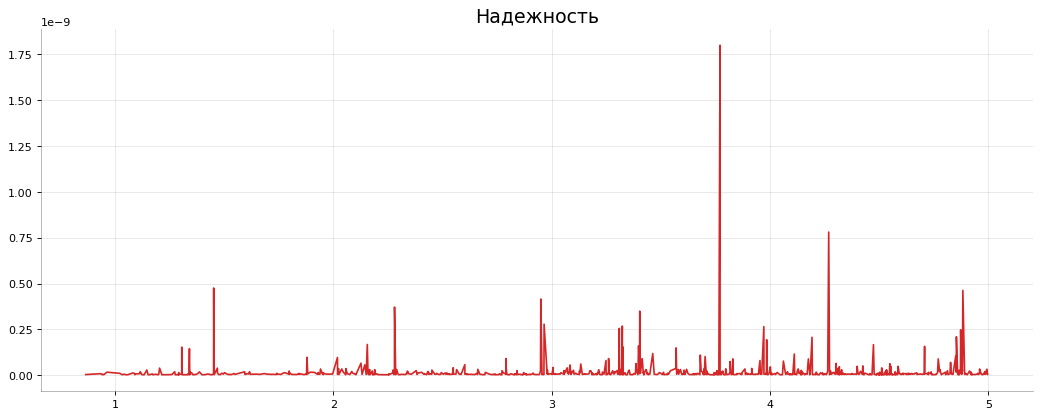

In [66]:
def plot_reli(x, y_pred, r):
    # Для быстроты кода
    sampled_index = np.sort(np.random.choice(len(x), min(1000, len(x)), replace=False))
    x = x[sampled_index]
    y_pred = y_pred[sampled_index]
    r = np.array(r)[sampled_index]
    
    y_best = np.zeros_like(y_pred)
    
    #Решаем диффур
    solver = ode(lambda x, y: f(x, y).tolist())
    solver.set_initial_value(y0, x0)
    
    for i, time in enumerate(x):
        h = solver.t - time
        y_best[i] = solver.integrate(h)
    
    # Считаем надежность
    rn = (np.clip(norm(abs(y_best - y_pred), axis=1), 1e-200, np.inf))
    mu = abs(r/rn)
    
    plot('Надежность', mu[20:], x[20:])
    
    

plot_reli(x, y_pred, r)

Если учесть, что погрешность изобращенная на графике имеет порядок точности 1e-8- 1e-9, то это можно назвать хорошим результатом

Так же проверим количество обращений к функции 2ух этапного метода с локальной погрешностью

In [74]:
for rtol, atol in zip([1e-3, 1e-5, 1e-10], [1e-3, 1e-5, 1e-10]):
    x, y_pred, info = _solver_diff_equations_local(f, x0, y0, params=params, x_end=x_end, 
                                               h=1e-6, rtol=rtol, atol=atol)
    h, r, num_calc = info
    print(f'Количество вызова f для {rtol = }, {atol = } - {num_calc}')

Количество вызова f для rtol = 0.001, atol = 0.001 - 5472
Количество вызова f для rtol = 1e-05, atol = 1e-05 - 52260
Количество вызова f для rtol = 1e-10, atol = 1e-10 - 16435698


Метод оппонент 27 - Метод Хойна или явный метод трапеций

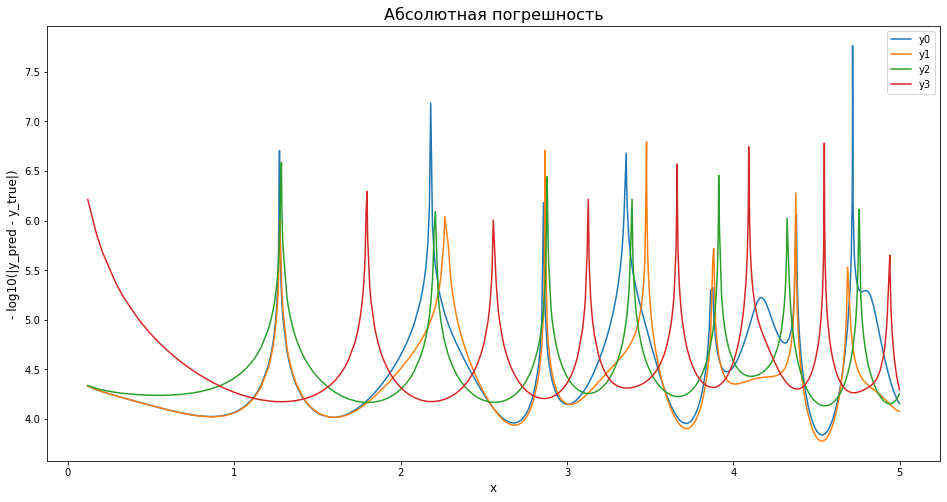

In [88]:
params = [1., 1., 1/2, 1/2] #c1 = 1

x, y_pred, info = _solver_diff_equations_local(f, x0, y0, params=params, x_end=x_end, 
                                           h=1e-6, rtol=1e-4, atol=1e-10)
h, r, num_calc = info
plot_loss(x, y_pred)

<Figure size 432x288 with 0 Axes>

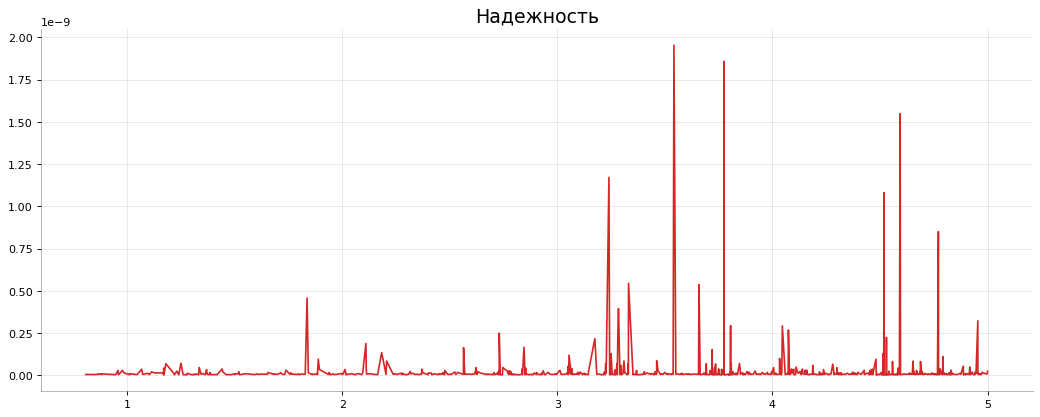

In [89]:
def plot_reli(x, y_pred, r):
    # Для быстроты кода
    sampled_index = np.sort(np.random.choice(len(x), min(1000, len(x)), replace=False))
    x = x[sampled_index]
    y_pred = y_pred[sampled_index]
    r = np.array(r)[sampled_index]
    
    y_best = np.zeros_like(y_pred)
    
    #Решаем диффур
    solver = ode(lambda x, y: f(x, y).tolist())
    solver.set_initial_value(y0, x0)
    
    for i, time in enumerate(x):
        h = solver.t - time
        y_best[i] = solver.integrate(h)
    
    # Считаем надежность
    rn = (np.clip(norm(abs(y_best - y_pred), axis=1), 1e-200, np.inf))
    mu = abs(r/rn)
    
    plot('Надежность', mu[20:], x[20:])
    

plot_reli(x, y_pred, r)

In [90]:
for rtol, atol in zip([1e-3, 1e-5, 1e-10], [1e-3, 1e-5, 1e-10]):
    x, y_pred, info = _solver_diff_equations_local(f, x0, y0, params=params, x_end=x_end, 
                                               h=1e-6, rtol=rtol, atol=atol)
    h, r, num_calc = info
    print(f'Количество вызова f для {rtol = }, {atol = } - {num_calc}')

Количество вызова f для rtol = 0.001, atol = 0.001 - 5472.0
Количество вызова f для rtol = 1e-05, atol = 1e-05 - 52260.0
Количество вызова f для rtol = 1e-10, atol = 1e-10 - 16435698.0


Если бы правая часть не зависила бы от y, то метод Хойна совпал бы с методом трапеций. А так практических различий между методами не обнаружено 